In [1]:
import numpy as np
import pandas as pd
from pandas import Series, DataFrame

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, BaggingRegressor
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.linear_model import ElasticNet, ElasticNetCV
from sklearn.svm import SVR
from mlxtend.regressor import StackingCVRegressor
from xgboost import XGBRegressor

from scipy.stats import skew, norm
from scipy.special import boxcox, inv_boxcox
from scipy.stats import boxcox_normmax
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler

import warnings
warnings.filterwarnings(action="ignore")

In [2]:
import os
os.chdir('D:\Projects\Bigmart')
os.getcwd()

'D:\\Projects\\Bigmart'

In [3]:
train=pd.read_csv("train.csv")
test=pd.read_csv("test.csv")

In [4]:
train.shape,test.shape

((8523, 12), (5681, 11))

In [5]:
train.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


## EDA

#### Target Variable

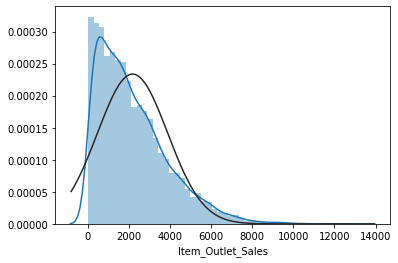

In [6]:
sns.distplot(train['Item_Outlet_Sales'],fit=norm)

In [7]:
print("Skewness: %f" % train['Item_Outlet_Sales'].skew())
print("Kurtosis: %f" % train['Item_Outlet_Sales'].kurt())

Skewness: 1.177531
Kurtosis: 1.615877


In [8]:
train['Item_Outlet_Sales'].describe()

count     8523.000000
mean      2181.288914
std       1706.499616
min         33.290000
25%        834.247400
50%       1794.331000
75%       3101.296400
max      13086.964800
Name: Item_Outlet_Sales, dtype: float64

Target Valiable is right skewed and needs to be normalized.

In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


- Most of the features are object type and we will check later whether they can be converted into numeric by applying label encoder. 
- Outlet_Establishment_Year - This feature is numeric but we will treat it as a categorical

In [10]:
cols=[]
for i in train.columns:
    if train[i].dtype !=object:
        if i in ['Outlet_Establishment_Year','Item_Outlet_Sales']:
            pass
        else:
            cols.append(i)

print(cols)

['Item_Weight', 'Item_Visibility', 'Item_MRP']


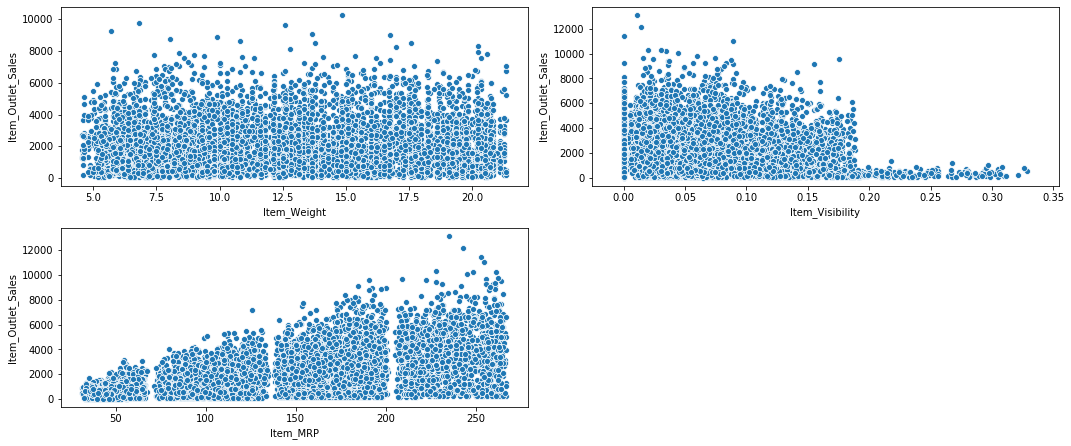

In [11]:
fig, axs = plt.subplots(2,0, sharey=True, figsize=(15, 12), tight_layout=True)

for i, feature in enumerate(cols,1):
    plt.subplot(4,2,i)
    sns.scatterplot(x=feature,y='Item_Outlet_Sales',data=train)

- Item Weight does seem to be affecting sales cosiderably. We can think of dropping this feature.
- Most of the products are having visibility zero - need to be imputed. Also, it is quite strange that sales are low for items which are more visible.
- Sales go high as item MRP goes high which is acceptable because total sales amount for that product is directly proportional to product price.

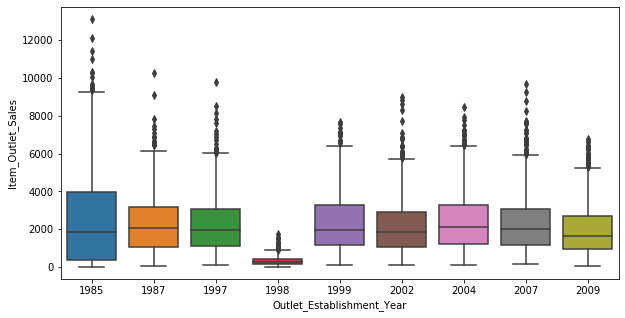

In [12]:
train['Outlet_Establishment_Year']=train['Outlet_Establishment_Year'].astype(str)

plt.figure(figsize=(10,5))
sns.boxplot(x='Outlet_Establishment_Year',y='Item_Outlet_Sales',data=train)

Outlet Establishment Year does not seem to have significant impact on sales. Also, Outlet Identifier & Outlet Establishment Year features are interlinked since every outlet has its unique establishment year except [OUT027, OUT019] - these two outlets are esstablished on the same year. We can drop this feature and consider outlet identifier instead.

In [13]:
train.groupby('Outlet_Establishment_Year')['Outlet_Identifier'].unique()

Outlet_Establishment_Year
1985    [OUT027, OUT019]
1987            [OUT013]
1997            [OUT046]
1998            [OUT010]
1999            [OUT049]
2002            [OUT045]
2004            [OUT035]
2007            [OUT017]
2009            [OUT018]
Name: Outlet_Identifier, dtype: object

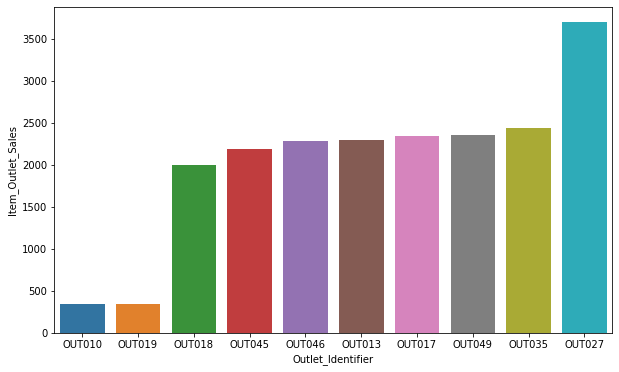

In [14]:
df=train.groupby(['Outlet_Identifier'],as_index=False).agg({'Item_Outlet_Sales':'mean'}).sort_values('Item_Outlet_Sales')
plt.figure(figsize=(10,6))
sns.barplot(x='Outlet_Identifier',y='Item_Outlet_Sales',data=df)

Two outlets have very low sales & one is having exeptionally high. We can further analyzie this by comparing which city does that store belong and which item types are sold there mostly also we can check their outlet size & outlet type.

In [15]:
train.groupby('Outlet_Location_Type').agg({'Item_Outlet_Sales':'mean'})

,Item_Outlet_Sales
Outlet_Location_Type,
Tier 1,1876.909159
Tier 2,2323.990559
Tier 3,2279.627651


In [16]:
train.groupby('Outlet_Size').agg({'Item_Outlet_Sales':'mean'})

,Item_Outlet_Sales
Outlet_Size,
High,2298.995256
Medium,2681.603542
Small,1912.149161


In [17]:
train['Item_Fat_Content'].value_counts()

Low Fat    5089
Regular    2889
LF          316
reg         117
low fat     112
Name: Item_Fat_Content, dtype: int64

As we see there are only two classes - low fat & reg fat. So these need to be merged.

In [18]:
train['Item_Type'].unique().tolist()

['Dairy',
 'Soft Drinks',
 'Meat',
 'Fruits and Vegetables',
 'Household',
 'Baking Goods',
 'Snack Foods',
 'Frozen Foods',
 'Breakfast',
 'Health and Hygiene',
 'Hard Drinks',
 'Canned',
 'Breads',
 'Starchy Foods',
 'Others',
 'Seafood']

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15]),
 <a list of 16 Text xticklabel objects>)

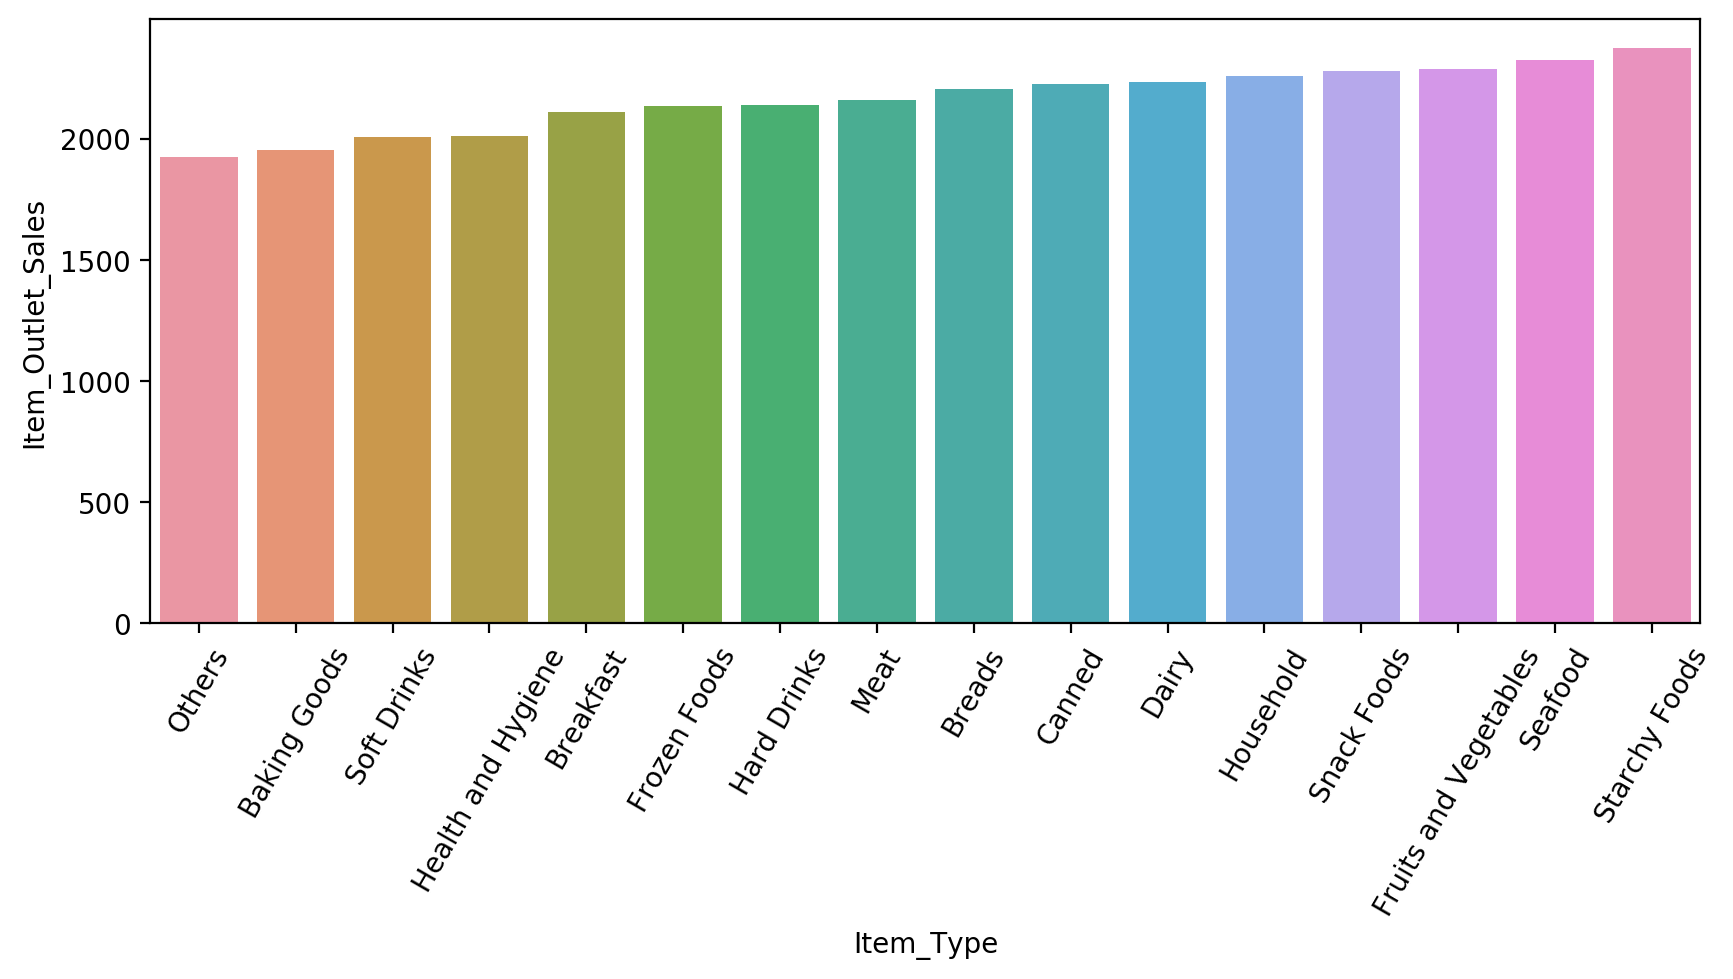

In [19]:
df=train.groupby(['Item_Type'],as_index=False).agg({'Item_Outlet_Sales':'mean'}).sort_values('Item_Outlet_Sales')
plt.figure(figsize=(10,4),dpi=200)
sns.barplot(x='Item_Type',y='Item_Outlet_Sales',data=df)
plt.xticks(rotation=60)

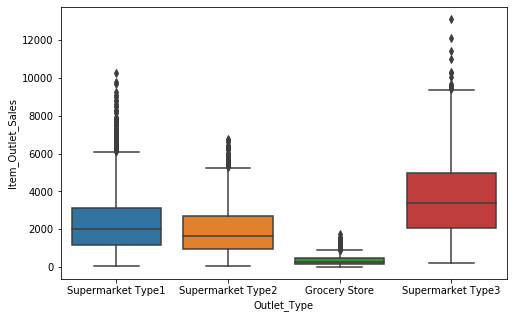

In [20]:
plt.figure(figsize=(8,5))
sns.boxplot(x='Outlet_Type',y='Item_Outlet_Sales',data=train)

In [21]:
train['Outlet_Type'].value_counts()

Supermarket Type1    5577
Grocery Store        1083
Supermarket Type3     935
Supermarket Type2     928
Name: Outlet_Type, dtype: int64

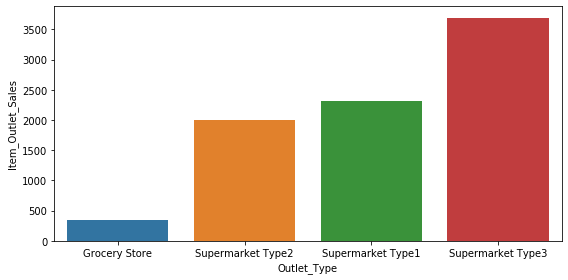

In [22]:
df=train.groupby(['Outlet_Type'],as_index=False).agg({'Item_Outlet_Sales':'mean'}).sort_values('Item_Outlet_Sales')
plt.figure(figsize=(8,4),tight_layout=True)
sns.barplot(x='Outlet_Type',y='Item_Outlet_Sales',data=df)

In [23]:
len(train['Item_Identifier'].unique())

1559

Will drop Item_Identifier feature as its having a lot of unique items. Also, Item_Type feature seems to be derived from item_identifier so can be used inplace of Item_Identifier.

## Data Preparation

In [24]:
train_ids=train[['Item_Identifier','Outlet_Identifier']]
test_ids=test[['Item_Identifier','Outlet_Identifier']]

In [25]:
#Split features & labels
train_labels=train['Item_Outlet_Sales'].reset_index(drop=True)
train_features=train.drop(['Item_Outlet_Sales'],axis=1)
test_features=test

#combining train & test data
all_data=pd.concat([train_features,test_features]).reset_index(drop=True)
all_data.shape

(14204, 11)

In [26]:
all_data.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1


__Cleaning Fat Feature__

In [27]:
all_data['Item_Fat_Content'].value_counts()

Low Fat    8485
Regular    4824
LF          522
reg         195
low fat     178
Name: Item_Fat_Content, dtype: int64

As we can see there are only two valid classes.

In [28]:
def fun(x):
    if x=='Low Fat':
        return 'LF'
    elif x=='low fat':
        return 'LF'
    elif x=='Regular':
        return 'reg'
    else:
        return x
    
all_data['Item_Fat_Content']=all_data['Item_Fat_Content'].apply(fun)

In [29]:
all_data['Item_Fat_Content'].value_counts()

LF     9185
reg    5019
Name: Item_Fat_Content, dtype: int64

### Outlier treatment

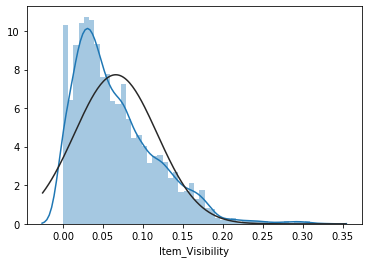

In [30]:
sns.distplot(train['Item_Visibility'],fit=norm)

- Any Item cannot have visibility completely zero. Will have to impute inplace of zeroes.
- Also this feature is right skewed so needs to be normalized.


**Let's explore a better substitute for zeroes.**

In [31]:
len(train[train['Item_Visibility']==0])

526

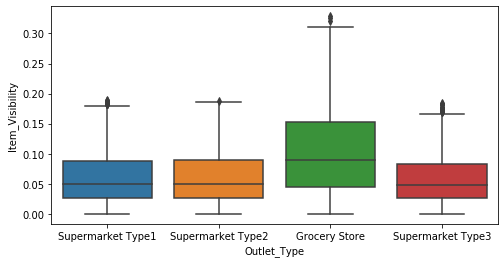

In [32]:
plt.figure(figsize=(8,4))
sns.boxplot(x='Outlet_Type',y='Item_Visibility',data=train)

Items are more visible at Grocery Stores than supermarkets.

In [33]:
train.groupby(['Item_Identifier','Outlet_Type'])['Item_Visibility'].mean()

Item_Identifier  Outlet_Type      
DRA12            Grocery Store        0.068535
                 Supermarket Type1    0.020522
                 Supermarket Type2    0.041113
DRA24            Grocery Store        0.068370
                 Supermarket Type1    0.039990
                                        ...   
NCZ53            Supermarket Type3    0.024359
NCZ54            Grocery Store        0.072976
                 Supermarket Type1    0.083459
                 Supermarket Type2    0.083699
                 Supermarket Type3    0.082956
Name: Item_Visibility, Length: 4314, dtype: float64

In [34]:
all_data.loc[all_data['Item_Visibility']==0,'Item_Visibility']=all_data.groupby(['Item_Identifier','Outlet_Type'])['Item_Visibility'].transform('mean')

In [35]:
len(all_data.loc[all_data['Item_Visibility']==0,'Item_Visibility'])

239

In [36]:
all_data.loc[all_data['Item_Visibility']==0,'Item_Visibility']=all_data.groupby(['Item_Identifier'])['Item_Visibility'].transform('mean')

In [37]:
len(all_data.loc[all_data['Item_Visibility']==0,'Item_Visibility'])

0

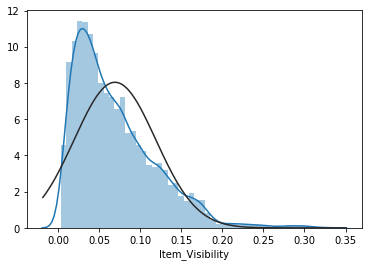

In [38]:
sns.distplot(all_data['Item_Visibility'],fit=norm)

**Exploring other numeric variables.**

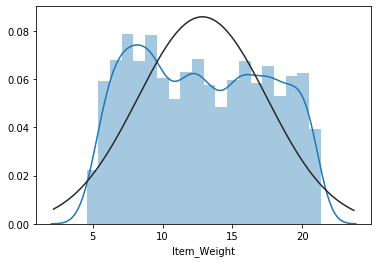

In [39]:
sns.distplot(train['Item_Weight'],fit=norm)

In [40]:
all_data['Item_Weight'].describe()

count    11765.000000
mean        12.792854
std          4.652502
min          4.555000
25%          8.710000
50%         12.600000
75%         16.750000
max         21.350000
Name: Item_Weight, dtype: float64

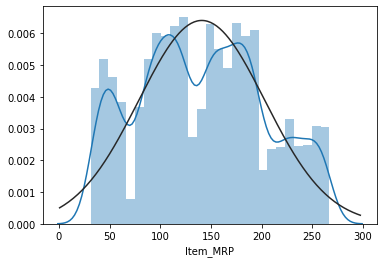

In [41]:
sns.distplot(train['Item_MRP'],fit=norm)

In [42]:
all_data['Item_MRP'].describe()

count    14204.000000
mean       141.004977
std         62.086938
min         31.290000
25%         94.012000
50%        142.247000
75%        185.855600
max        266.888400
Name: Item_MRP, dtype: float64

### Missing Values Treatment

In [43]:
all_data.isnull().sum()

Item_Identifier                 0
Item_Weight                  2439
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  4016
Outlet_Location_Type            0
Outlet_Type                     0
dtype: int64

We will drop these two variables since both contain missing valuse more than 15%

In [44]:
all_data.drop(columns=['Item_Weight','Outlet_Size'],inplace=True)
all_data.isnull().sum()

Item_Identifier              0
Item_Fat_Content             0
Item_Visibility              0
Item_Type                    0
Item_MRP                     0
Outlet_Identifier            0
Outlet_Establishment_Year    0
Outlet_Location_Type         0
Outlet_Type                  0
dtype: int64

In [45]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14204 entries, 0 to 14203
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            14204 non-null  object 
 1   Item_Fat_Content           14204 non-null  object 
 2   Item_Visibility            14204 non-null  float64
 3   Item_Type                  14204 non-null  object 
 4   Item_MRP                   14204 non-null  float64
 5   Outlet_Identifier          14204 non-null  object 
 6   Outlet_Establishment_Year  14204 non-null  object 
 7   Outlet_Location_Type       14204 non-null  object 
 8   Outlet_Type                14204 non-null  object 
dtypes: float64(2), object(7)
memory usage: 998.8+ KB


## Data Transformation

In [46]:
from sklearn.preprocessing import PowerTransformer
power = PowerTransformer(method='box-cox', standardize=True)

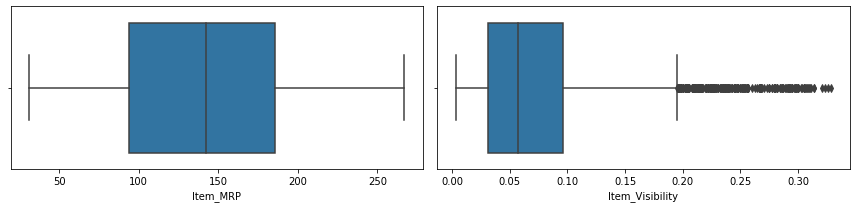

In [47]:
fig, ax=plt.subplots(ncols=2,tight_layout=True,figsize=(12,3))
sns.boxplot(all_data['Item_MRP'],ax=ax[0])
sns.boxplot(all_data['Item_Visibility'],ax=ax[1])

These two variables are completely at different scale and need to be transformed.

In [48]:
all_data[['Item_Visibility','Item_MRP']]=power.fit_transform(all_data[['Item_Visibility','Item_MRP']])

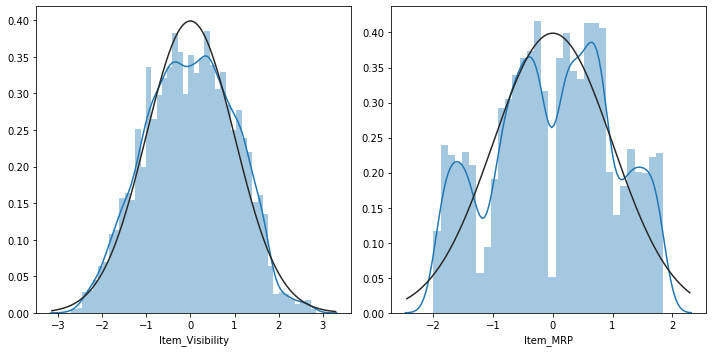

In [49]:
fig,ax=plt.subplots(ncols=2,figsize=(10,5),tight_layout=True)
sns.distplot(all_data['Item_Visibility'],fit=norm,ax=ax[0])
sns.distplot(all_data['Item_MRP'],fit=norm,ax=ax[1])

****

**Nomalizing target variable**

Instantiating another object of power transformer for target variable.

In [50]:
power1 = PowerTransformer(method='box-cox', standardize=True)

In [51]:
train_labels=np.array(train_labels).reshape(-1,1)
train_labels

array([[3735.138 ],
       [ 443.4228],
       [2097.27  ],
       ...,
       [1193.1136],
       [1845.5976],
       [ 765.67  ]])

In [52]:
train_labels=power1.fit_transform(train_labels)

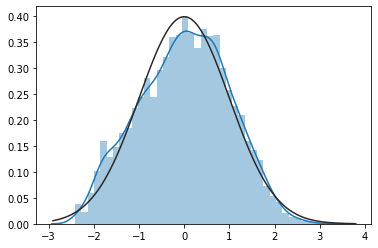

In [53]:
sns.distplot(train_labels,fit=norm)

In [54]:
power.lambdas_, power1.lambdas_

(array([0.22821532, 0.69262803]), array([0.34647756]))

**Dropping Columns**

In [55]:
all_data.drop(columns=['Item_Identifier','Outlet_Establishment_Year'],inplace=True)

In [56]:
all_data.head()

,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Location_Type,Outlet_Type
0,LF,-1.437274,Dairy,1.626498,OUT049,Tier 1,Supermarket Type1
1,reg,-1.252691,Soft Drinks,-1.603338,OUT018,Tier 3,Supermarket Type2
2,LF,-1.394239,Meat,0.082011,OUT049,Tier 1,Supermarket Type1
3,reg,-1.331973,Fruits and Vegetables,0.692011,OUT010,Tier 3,Grocery Store
4,LF,-2.229466,Household,-1.483297,OUT013,Tier 3,Supermarket Type1


In [57]:
all_data=pd.get_dummies(all_data)

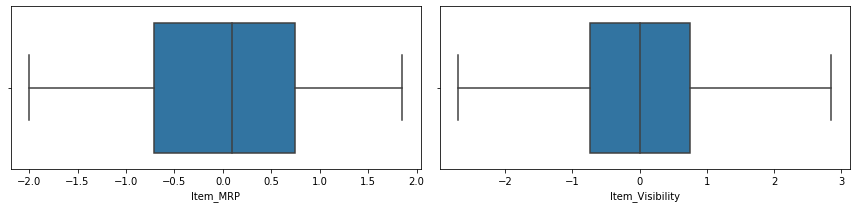

In [58]:
fig, ax=plt.subplots(ncols=2,tight_layout=True,figsize=(12,3))
sns.boxplot(all_data['Item_MRP'],ax=ax[0])
sns.boxplot(all_data['Item_Visibility'],ax=ax[1])

### Splitting into train & test again

In [59]:
X=all_data.iloc[:len(train_labels),:]
X_test=all_data.iloc[len(train_labels):,:]
X.shape,train_labels.shape,X_test.shape

((8523, 37), (8523, 1), (5681, 37))

In [60]:
all_data.shape

(14204, 37)

In [61]:
all_data.to_csv("alldata.csv",index=False)

## Models Training

In [62]:
# Setup cross validation folds
kf = KFold(n_splits=12, random_state=10, shuffle=True)

In [63]:
# Define error metrics
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

def cv_rmse(model, X=X):
    rmse = np.sqrt(-cross_val_score(model, X, train_labels, scoring="neg_mean_squared_error", cv=kf))
    return (rmse)

In [64]:
model_score={}

__Support Vector Regression__

In [65]:
svr=SVR(C=1, cache_size=200, coef0=0.0, degree=2, epsilon=0.5, gamma='scale',
    kernel='poly', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [66]:
score = cv_rmse(svr)
print("svr: {:.4f} ({:.4f})".format(score.mean(), score.std()))
model_score['svr']=(score.mean(), score.std())

svr: 0.5518 (0.0168)


In [67]:
svr.fit(X,train_labels)

SVR(C=1, cache_size=200, coef0=0.0, degree=2, epsilon=0.5, gamma='scale',
    kernel='poly', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [68]:
x_pred=svr.predict(X)

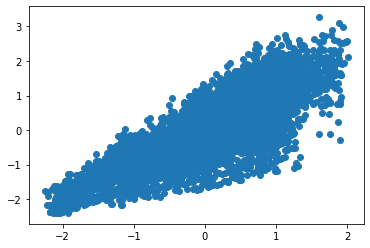

In [69]:
plt.scatter(x_pred,train_labels)

__Random Forest Regressor__

In [70]:
rf=RandomForestRegressor(n_estimators=170,max_depth=20, max_features=7)

In [71]:
score = cv_rmse(rf)
print("rf: {:.4f} ({:.4f})".format(score.mean(), score.std()))
model_score['rf']=(score.mean(), score.std())

rf: 0.5750 (0.0163)


**GradientBoostingRegressor**

In [72]:
gbr=GradientBoostingRegressor(learning_rate=0.1,max_depth=30,max_features=7)

In [73]:
score = cv_rmse(gbr)
print("gbr: {:.4f} ({:.4f})".format(score.mean(), score.std()))
model_score['gbr']=(score.mean(), score.std())

gbr: 0.6237 (0.0127)


**RidgeRegression**

In [74]:
ridge=Ridge(alpha=20)

In [75]:
score = cv_rmse(ridge)
print("ridge: {:.4f} ({:.4f})".format(score.mean(), score.std()))
model_score['ridge']=(score.mean(), score.std())

ridge: 0.5593 (0.0133)


**ElasticNet**

In [76]:
enet=ElasticNetCV(l1_ratio=[.1, .5, .7, .9, .95, .99, 1],
                 eps=0.001,n_alphas=100,max_iter=1000000)

In [77]:
enet.fit(X,train_labels)

ElasticNetCV(alphas=None, copy_X=True, cv=None, eps=0.001, fit_intercept=True,
             l1_ratio=[0.1, 0.5, 0.7, 0.9, 0.95, 0.99, 1], max_iter=1000000,
             n_alphas=100, n_jobs=None, normalize=False, positive=False,
             precompute='auto', random_state=None, selection='cyclic',
             tol=0.0001, verbose=0)

In [78]:
score = cv_rmse(enet)
print("enet: {:.4f} ({:.4f})".format(score.mean(), score.std()))
model_score['enet']=(score.mean(), score.std())

enet: 0.5589 (0.0134)


__RidgeRegression__

In [79]:
ridge.fit(X,train_labels)

Ridge(alpha=20, copy_X=True, fit_intercept=True, max_iter=None, normalize=False,
      random_state=None, solver='auto', tol=0.001)

In [80]:
ridge_pred=ridge.predict(X)

In [81]:
MAE=mean_squared_error(train_labels,ridge_pred)
MAE

0.31086082104863055

__XGBoost Regressor__

In [82]:
xgb=XGBRegressor(learning_rate=0.1,max_depth=3,min_child_weight=5,n_estimators=100,objective='reg:linear')

In [83]:
score = cv_rmse(xgb)
print("xgb: {:.4f} ({:.4f})".format(score.mean(), score.std()))
model_score['xgb']=(score.mean(), score.std())

[23:18:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.2.0/src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.
[23:18:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.2.0/src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.
[23:18:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.2.0/src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.
[23:18:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.2.0/src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.
[23:18:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.2.0/src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.
[23:18:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.2.0/src/objective/regression_obj.cu:17

In [84]:
model_score

{'svr': (0.551768285164238, 0.016836475193336697),
 'rf': (0.5750195188492694, 0.016348126505886774),
 'gbr': (0.6237139244104005, 0.012673947883600626),
 'ridge': (0.5593252826481512, 0.013258061496454667),
 'enet': (0.5589280083584076, 0.013387137988368018),
 'xgb': (0.551238664492489, 0.014141860597268399)}

In [85]:
score_df=pd.DataFrame.from_dict(model_score,orient='index',columns=['mean','std'])
score_df['model']=score_df.index
score_df=score_df.reset_index(drop=True)
score_df=score_df.sort_values('mean',ascending=False)

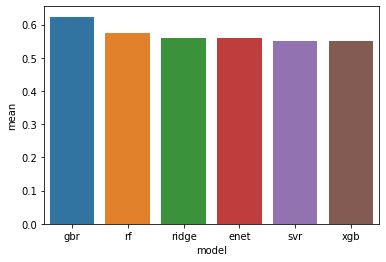

In [86]:
sns.barplot(x='model',y='mean',data=score_df)

__XGBoost is performing better__

In [87]:
xgb.fit(X,train_labels)

[23:18:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.2.0/src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.
[23:18:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.2.0/src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=5, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1,
             objective='reg:linear', random_state=0, reg_alpha=0, reg_lambda=1,
             scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [88]:
pred=xgb.predict(X_test)

In [89]:
type(pred)

numpy.ndarray

In [90]:
pred_conv=pred.reshape(-1,1)
pred_conv=power1.inverse_transform(pred_conv)

In [91]:
pred_conv

array([[1588.1117],
       [1277.5067],
       [ 536.2634],
       ...,
       [1668.5222],
       [3437.437 ],
       [1158.4606]], dtype=float32)

__Submission__

In [92]:
sub=pd.DataFrame()
sub['Item_Identifier']=test_ids['Item_Identifier']
sub['Outlet_Identifier']=test_ids['Outlet_Identifier']
sub['Item_Outlet_Sales']=pred_conv

In [93]:
sub.to_csv('xgb.csv',index=False)

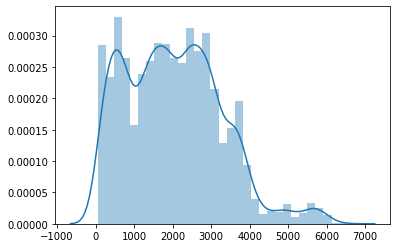

In [94]:
sns.distplot(pred_conv)

In [95]:
pred_conv.max(),pred_conv.min()

(6546.0425, 49.984444)

**Predicting sales of the same training data**

In [96]:
x_pred=xgb.predict(X)

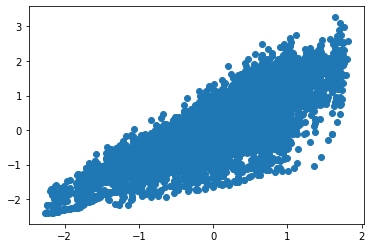

In [97]:
plt.scatter(x_pred,train_labels)

In [98]:
x_pred=x_pred.reshape(-1,1)
x_pred=power1.inverse_transform(x_pred)

In [99]:
train_conv=power1.inverse_transform(train_labels)

In [100]:
residuals=x_pred-train_conv

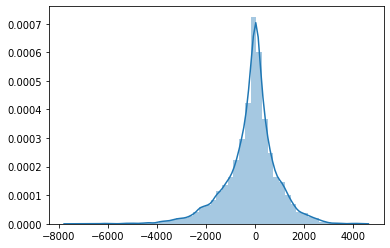

In [101]:
sns.distplot(residuals)

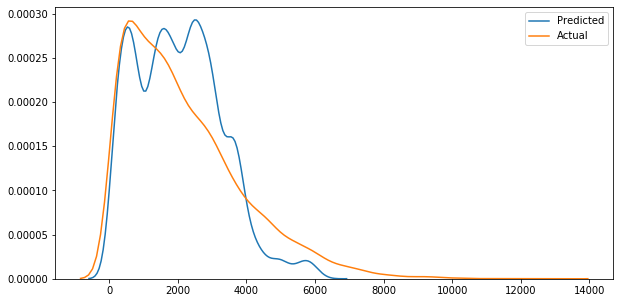

In [102]:
plt.figure(figsize=(10,5))
sns.distplot(x_pred,hist=False,label='Predicted')
sns.distplot(train_conv,hist=False,label='Actual')